<a href="https://colab.research.google.com/github/Saplos/arise-final-challenge/blob/master/arise_final_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

solaaremu.pelumi@gmail.com

## **Comparison of two loan pre-deliquency model**

This project is the captsone project for the Arise-paylater internship, a 6-week long internship to develop the datascience capabilities of participants. 

The capstone project involves developing two loan pre-deliquency models using Random Forest and Neural Network Algorithms. 

The entire machine learning pipeline is explored during the course of this project.

####**Importing necessary libraries**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#### **Importing the data from google sheets**

In [0]:
!pip install --upgrade -q gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Loan pre-deliquency dataset').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
df=pd.DataFrame.from_records(rows)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



####**Date Preprocessing**

**Formatting the DataFrame to include appropriate column names and datatype**

In [0]:
#This changes the column names to the appropriate values
df.columns=df.iloc[0]
#This drops the row containing the column names from the dataframe
df=df.drop(df.index[0]) 
#This resets the index of the dataframe 
df=df.reset_index(drop=True) 

In [0]:
#This fixes pandas importing the Null value from google sheets as string 'Null'
df=df.replace(to_replace='Null', value=np.NaN)

**Handling Missing Values**

In [0]:
#This prints the initial sum of missing values per column
df.isna().sum()

0
clientId                          0
clientIncome                      0
incomeVerified                  103
clientAge                         0
clientGender                      0
clientMaritalStatus               6
clientLoanPurpose                 0
clientResidentialStauts        1136
clientState                       1
clientTimeAtEmployer           4194
clientNumberPhoneContacts      2708
clientAvgCallsPerDay           2687
loanId                            0
loanType                          0
loanNumber                        0
applicationDate                   0
approvalDate                      0
declinedDate                 159589
disbursementDate                  0
payout_status                     0
dueDate                           0
paidAt                        29800
loanAmount                        0
interestRate                      0
loanTerm                          0
max_amount_taken                  0
max_tenor_taken                   0
firstPaymentDefault       

In [0]:
#This drops the columns deemed necessary
for item in ['declinedDate','paidAt','payout_status','loanType','approvalDate','applicationDate','disbursementDate','dueDate','clientId']:
  df.drop(item,axis=1,inplace=True)
#This drops rows with entries of Null
df.dropna(subset=['clientState','clientTimeAtEmployer','incomeVerified','clientAvgCallsPerDay','clientNumberPhoneContacts','clientResidentialStauts','clientMaritalStatus'],inplace=True)


In [0]:
#This prints the sum of missing values per column after cleaning
df.isna().sum()

0
clientIncome                 0
incomeVerified               0
clientAge                    0
clientGender                 0
clientMaritalStatus          0
clientLoanPurpose            0
clientResidentialStauts      0
clientState                  0
clientTimeAtEmployer         0
clientNumberPhoneContacts    0
clientAvgCallsPerDay         0
loanId                       0
loanNumber                   0
loanAmount                   0
interestRate                 0
loanTerm                     0
max_amount_taken             0
max_tenor_taken              0
firstPaymentDefault          0
firstPaymentRatio            0
loanDefault                  0
dtype: int64

**Ensuring columns are of the appropriate datatype**

In [0]:
#This fixes errors in state column
df['clientState']=df['clientState'].replace(to_replace='LAGOS ', value='LAGOS')
df['clientState']=df['clientState'].replace(to_replace='OJO', value='OYO')

In [0]:
#This displays the current datatypes
df.dtypes

0
clientIncome                 object
incomeVerified               object
clientAge                    object
clientGender                 object
clientMaritalStatus          object
clientLoanPurpose            object
clientResidentialStauts      object
clientState                  object
clientTimeAtEmployer         object
clientNumberPhoneContacts    object
clientAvgCallsPerDay         object
loanId                       object
loanNumber                   object
loanAmount                   object
interestRate                 object
loanTerm                     object
max_amount_taken             object
max_tenor_taken              object
firstPaymentDefault          object
firstPaymentRatio            object
loanDefault                  object
dtype: object

In [0]:
#This changes certain series to numeric datatype
for item in ['loanDefault','firstPaymentRatio','firstPaymentDefault','max_tenor_taken','max_amount_taken','interestRate','loanAmount','clientAvgCallsPerDay','clientNumberPhoneContacts','clientAge','clientIncome']:
  df[item]=pd.to_numeric(df[item])


**One-hot Encoding Categorical Variables**

In [0]:
#This forces categorical variables and one hot encodes
for item in ['loanTerm','loanNumber','clientTimeAtEmployer','clientState','clientResidentialStauts','clientLoanPurpose','clientGender','clientMaritalStatus','incomeVerified']:
  df[item]=pd.Categorical(df[item])
  df=pd.concat([df,pd.get_dummies(df[item],prefix=item)],axis=1)
  df.drop(item,axis=1,inplace=True)

In [0]:
#This sets the index to the LoanId column
df=df.set_index(['loanId'])

In [0]:
#This prints the list of features and datatypes after preprocessing
print(df.dtypes.to_string())

clientIncome                                 float64
clientAge                                      int64
clientNumberPhoneContacts                      int64
clientAvgCallsPerDay                         float64
loanAmount                                     int64
interestRate                                 float64
max_amount_taken                               int64
max_tenor_taken                                int64
firstPaymentDefault                            int64
firstPaymentRatio                            float64
loanDefault                                    int64
loanTerm_180                                   uint8
loanTerm_60                                    uint8
loanTerm_90                                    uint8
loanNumber_1                                   uint8
loanNumber_10                                  uint8
loanNumber_11                                  uint8
loanNumber_12                                  uint8
loanNumber_13                                 

####**Exploring numeric columns of the dataset using boxplot to check for outliers**

**Plotting the initial boxplots before removing outliers**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


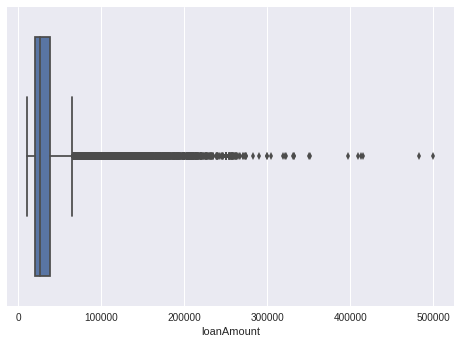

In [0]:
sns.boxplot(df['loanAmount'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


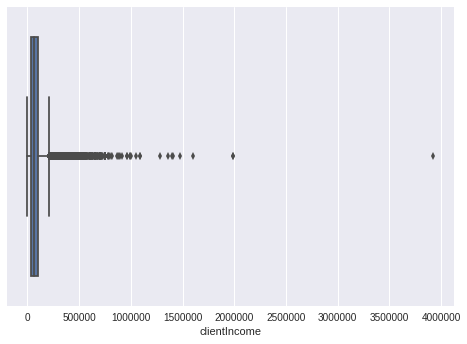

In [0]:
sns.boxplot(df['clientIncome'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


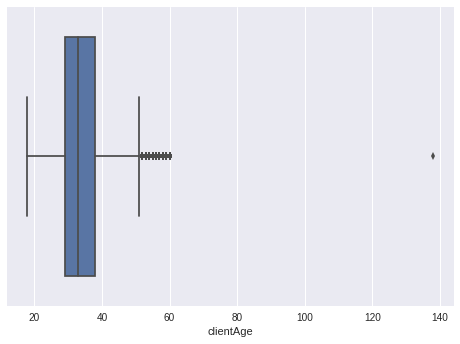

In [0]:
sns.boxplot(df['clientAge'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


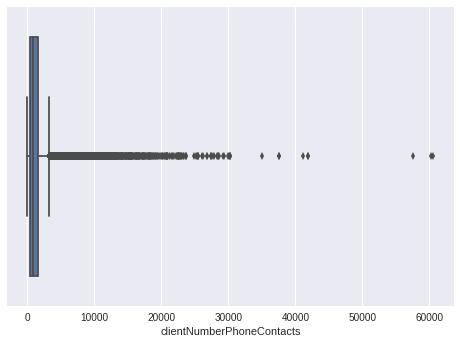

In [0]:
sns.boxplot(df['clientNumberPhoneContacts'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


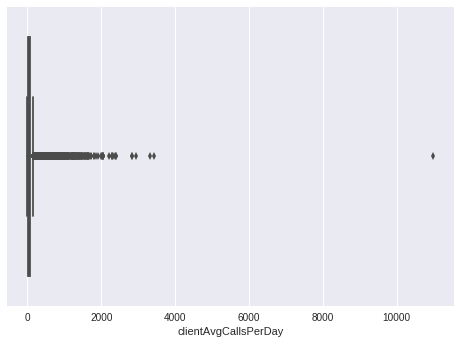

In [0]:
sns.boxplot(df['clientAvgCallsPerDay'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


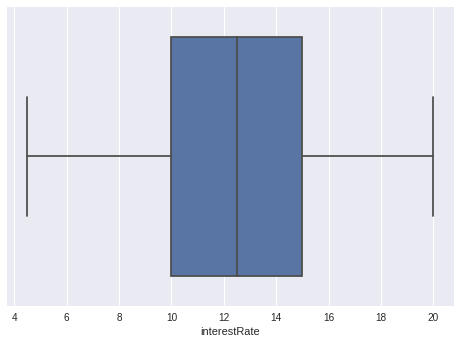

In [0]:
sns.boxplot(df['interestRate'])

**Identifying and removing outliers**

In [0]:
#Explore Z scores
for item in ['loanAmount','clientIncome','clientAge','clientNumberPhoneContacts','clientAvgCallsPerDay']:
  z=np.abs(stats.zscore(df[item]))
  drop_z=(np.where(z>3))
  drop_z_list=list(drop_z[0])
  df.drop(df.iloc[drop_z_list].index,inplace=True)

**Plotting the numeric columns using boxplots after removing outliers**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


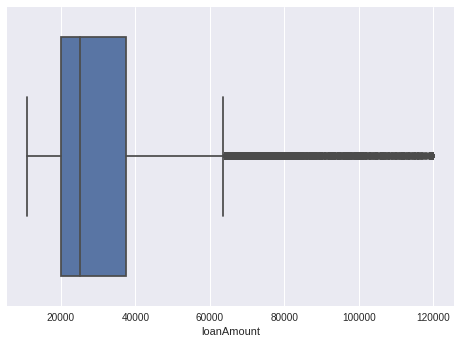

In [0]:
sns.boxplot(df['loanAmount'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


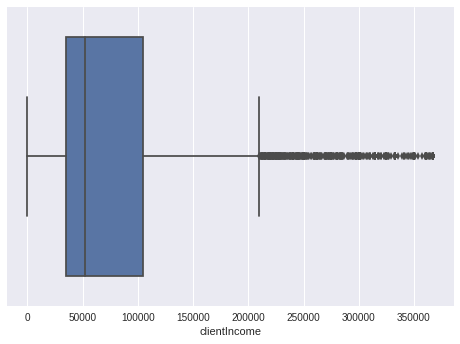

In [0]:
sns.boxplot(df['clientIncome'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


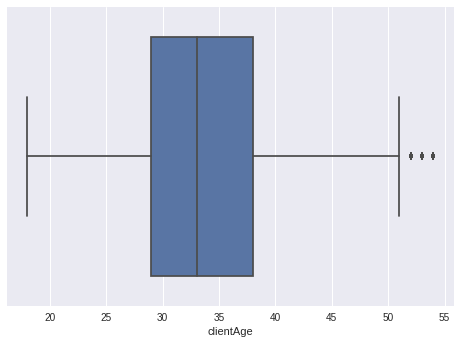

In [0]:
sns.boxplot(df['clientAge'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


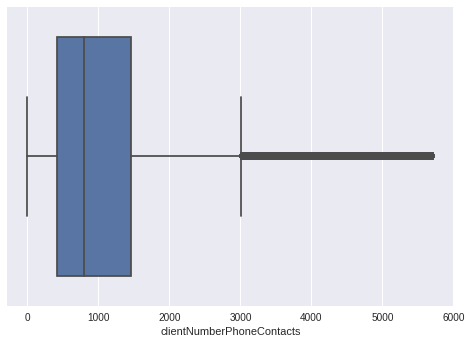

In [0]:
sns.boxplot(df['clientNumberPhoneContacts'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


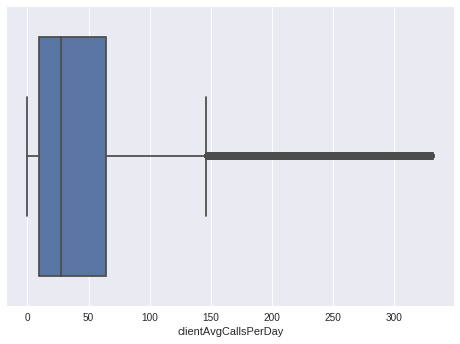

In [0]:
sns.boxplot(df['clientAvgCallsPerDay'])

**Feature Engineering**

In [0]:
#Creates the column ratioLoanIncome which represents the ratio of the client's loan amount to his income
df['ratioLoanIncome']=df['loanAmount']/df['clientIncome']
df

,clientIncome,clientAge,clientNumberPhoneContacts,clientAvgCallsPerDay,loanAmount,interestRate,max_amount_taken,max_tenor_taken,firstPaymentDefault,firstPaymentRatio,...,clientGender_FEMALE,clientGender_MALE,clientMaritalStatus_Divorced,clientMaritalStatus_Married,clientMaritalStatus_Separated,clientMaritalStatus_Single,clientMaritalStatus_Widowed,incomeVerified_false,incomeVerified_true,ratioLoanIncome
loanId,,,,,,,,,,,,,,,,,,,,,
302867672,58763.82,29,3131,83.900000,48000,7.5,0,1,1,0.000000,...,1,0,0,1,0,0,0,0,1,0.816829
302178646371,35000.00,45,722,8.000000,43000,10.0,0,0,0,0.000000,...,1,0,0,1,0,0,0,1,0,1.228571
302832638,105000.00,34,1159,45.560345,31500,12.5,1,1,0,0.000000,...,0,1,0,1,0,0,0,1,0,0.300000
302664395,192500.00,28,571,6.659686,31500,12.5,1,1,1,1.000000,...,0,1,0,0,0,1,0,1,0,0.163636
302388360535,52500.00,29,207,16.000000,43000,10.0,0,0,0,0.000000,...,1,0,0,0,0,1,0,1,0,0.819048
302789501,60000.00,35,270,11.402273,44500,5.0,0,1,0,0.000000,...,1,0,0,0,0,1,0,0,1,0.741667
303161580,103133.77,31,473,91.333333,70000,7.5,1,1,0,0.000000,...,0,1,0,1,0,0,0,0,1,0.678730
301872918670,100000.00,36,1289,95.487500,70000,7.5,0,1,0,0.000000,...,0,1,0,1,0,0,0,0,1,0.700000
301876312275,35000.00,28,253,55.000000,73500,7.5,0,1,1,0.000000,...,1,0,0,1,0,0,0,1,0,2.100000


####**Dataset Scaling of numeric parameters**

In [0]:
for item in ['clientIncome','clientAge','clientNumberPhoneContacts','clientAvgCallsPerDay','loanAmount','ratioLoanIncome']:
  df[item]=(scale(df[(item)]) )
 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [0]:
print(df.head().to_string())

              clientIncome  clientAge  clientNumberPhoneContacts  clientAvgCallsPerDay  loanAmount  interestRate  max_amount_taken  max_tenor_taken  firstPaymentDefault  firstPaymentRatio  loanDefault  loanTerm_180  loanTerm_60  loanTerm_90  loanNumber_1  loanNumber_10  loanNumber_11  loanNumber_12  loanNumber_13  loanNumber_14  loanNumber_15  loanNumber_16  loanNumber_17  loanNumber_18  loanNumber_19  loanNumber_2  loanNumber_20  loanNumber_21  loanNumber_22  loanNumber_23  loanNumber_24  loanNumber_25  loanNumber_26  loanNumber_27  loanNumber_28  loanNumber_29  loanNumber_3  loanNumber_30  loanNumber_31  loanNumber_32  loanNumber_4  loanNumber_5  loanNumber_6  loanNumber_7  loanNumber_8  loanNumber_9  clientTimeAtEmployer_-5  clientTimeAtEmployer_-6  clientTimeAtEmployer_-7  clientTimeAtEmployer_0  clientTimeAtEmployer_1  clientTimeAtEmployer_10  clientTimeAtEmployer_11  clientTimeAtEmployer_12  clientTimeAtEmployer_13  clientTimeAtEmployer_14  clientTimeAtEmployer_15  clientTimeAtEm

####**Splitting the Dataset**

In [0]:
#This utlilises a 70-30 split
X_train, X_test, y_train, y_test = tts( df.drop(['loanDefault'],inplace=False,axis=1), df['loanDefault'], test_size=0.3, random_state=42)

####**Handling Imbalance**

In [0]:
#The smote technique is utilised here to handle imbalance of the dataset
sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [0]:
#This provides the shape of the newly created dataset
X_train.shape

(141488, 142)

####**Implementing the Random Forest Classifier**

In [0]:
#Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=20, random_state=42)  
classifier.fit(X_train, y_train)
y_train_pred_rfc=classifier.predict(X_train)
y_pred_rfc = classifier.predict(X_test) 

In [0]:
#This prints a table of the features and their importance as determined by the random forest classifier.
print(pd.DataFrame(X_test.columns,classifier.feature_importances_).to_string())

                                                      0
3.472548e-02                               clientIncome
3.760011e-02                                  clientAge
4.142752e-02                  clientNumberPhoneContacts
4.131101e-02                       clientAvgCallsPerDay
3.000648e-02                                 loanAmount
1.357806e-02                               interestRate
1.766261e-02                           max_amount_taken
7.061476e-03                            max_tenor_taken
2.423191e-01                        firstPaymentDefault
2.082312e-01                          firstPaymentRatio
2.531340e-03                               loanTerm_180
5.461506e-03                                loanTerm_60
4.040336e-03                                loanTerm_90
2.311105e-03                               loanNumber_1
6.453148e-04                              loanNumber_10
4.171707e-04                              loanNumber_11
2.048611e-04                              loanNu

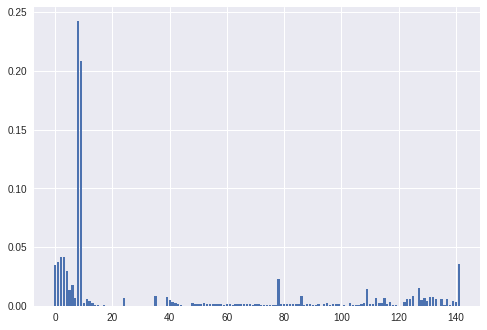

In [0]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

In [0]:
#Function used to graphically illustrate confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

**Performance of Random Forest Classifier on the training dataset**

Confusion matrix, without normalization
[[70733    11]
 [  311 70433]]


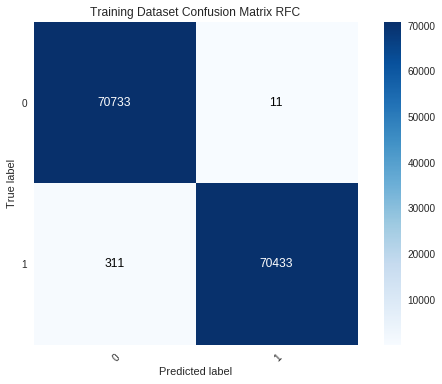

In [0]:
#This prints and plots the confusion matrix for the rfc classifier on the training dataset
class_names=np.array((0,1))
plot_confusion_matrix(y_train, y_train_pred_rfc, classes=class_names, title='Training Dataset Confusion Matrix RFC')

In [0]:
#Checks the performance on Training Dataset
print(classification_report(y_train,y_train_pred_rfc))  
print(accuracy_score(y_train, y_train_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70744
           1       1.00      1.00      1.00     70744

   micro avg       1.00      1.00      1.00    141488
   macro avg       1.00      1.00      1.00    141488
weighted avg       1.00      1.00      1.00    141488

0.9977241886237702


AUC: 1.000


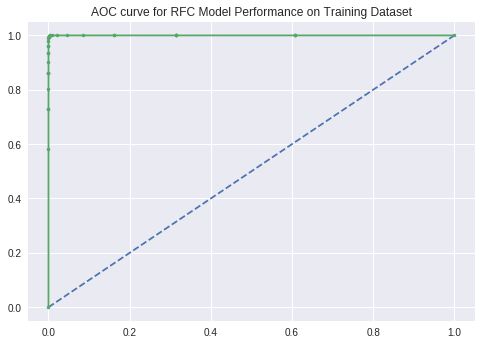

In [0]:
#Plotting AOC curve
probs_rfc_train = classifier.predict_proba(X_train)
probs_rfc_train = probs_rfc_train[:, 1]
auc_rfc_train = roc_auc_score(y_train, probs_rfc_train)
print('AUC: %.3f' % auc_rfc_train)
# calculate roc curve
fpr_rfc_train, tpr_rfc_train, thresholds_rfc_train = roc_curve(y_train, probs_rfc_train)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.title('AOC curve for RFC Model Performance on Training Dataset')
plt.plot(fpr_rfc_train, tpr_rfc_train, marker='.')
# show the plot
plt.show()

**Performance of Random Forest Classifier on the Test dataset**

Confusion matrix, without normalization
[[28298  1673]
 [ 4819  7131]]


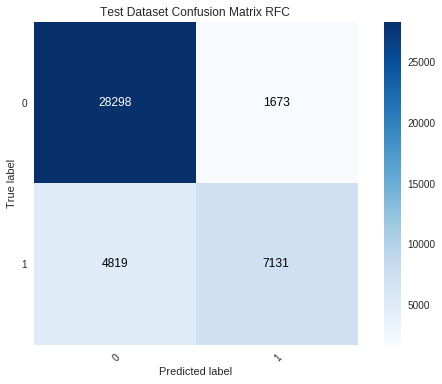

In [0]:
class_names=np.array((0,1))
plot_confusion_matrix(y_test, y_pred_rfc, classes=class_names, title='Test Dataset Confusion Matrix RFC')

In [0]:
#Checks the performance on Test Dataset
print(classification_report(y_test,y_pred_rfc))  
print(accuracy_score(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90     29971
           1       0.81      0.60      0.69     11950

   micro avg       0.85      0.85      0.85     41921
   macro avg       0.83      0.77      0.79     41921
weighted avg       0.84      0.85      0.84     41921

0.8451372820304859


AUC: 0.860


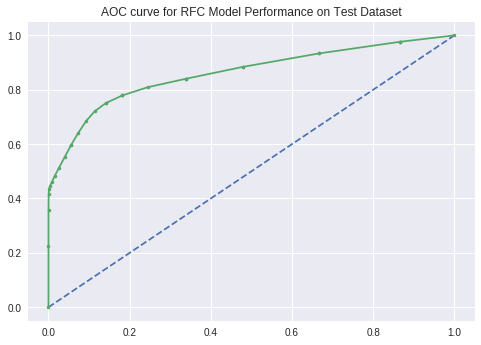

In [0]:
#Plotting AOC curve
probs_rfc = classifier.predict_proba(X_test)
probs_rfc = probs_rfc[:, 1]
auc_rfc = roc_auc_score(y_test, probs_rfc)
print('AUC: %.3f' % auc_rfc)
# calculate roc curve
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, probs_rfc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rfc, tpr_rfc, marker='.')
plt.title('AOC curve for RFC Model Performance on Test Dataset')
# show the plot
plt.show()

It is interesting to note that on comparison of the performance metrics for the training dataset and test dataset, the training outperforms the test significantly. This is indicative of the model overfitting to the dataset and can be fixed by utilising hyperparameter tuning.

####**Implementing  HyperParameter Tuning for Random Forest Classifier**

**Random Hyperparameter grid**

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


**Random Search Training**

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 198.2min


**Implemeting best features from the random search**

In [0]:
#This fits the best features from the random search
rfc_random=RandomForestClassifier(n_estimators=80, max_features=0.91, min_samples_split=0.42, max_depth=10)
rfc_random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=0.91, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.42,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
#This predicts the target for both the training and test datasets
y_train_pred_rfc_random=rfc_random.predict(X_train)
y_pred_rfc_random = rfc_random.predict(X_test) 

**Performance of the Tuned Random Forest Classifer on training dataset**

Confusion matrix, without normalization
[[62370  8374]
 [13486 57258]]


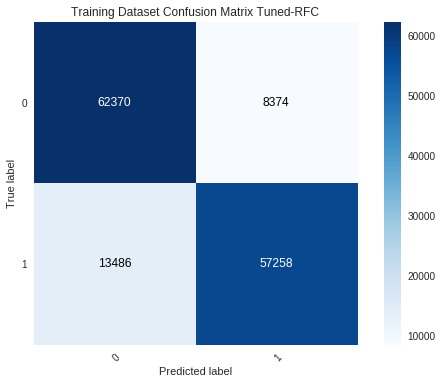

In [0]:
#This prints and plots the confusion matrix of the Tuned model on the training dataset
class_names=np.array((0,1))
plot_confusion_matrix(y_train, y_train_pred_rfc_random, classes=class_names, title='Training Dataset Confusion Matrix Tuned-RFC')

In [0]:
#Checks the Tuned performance on Training Dataset
print(classification_report(y_train,y_train_pred_rfc_random))  
print(accuracy_score(y_train, y_train_pred_rfc_random))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     70744
           1       0.87      0.81      0.84     70744

   micro avg       0.85      0.85      0.85    141488
   macro avg       0.85      0.85      0.85    141488
weighted avg       0.85      0.85      0.85    141488

0.8454992649553319


AUC: 0.885


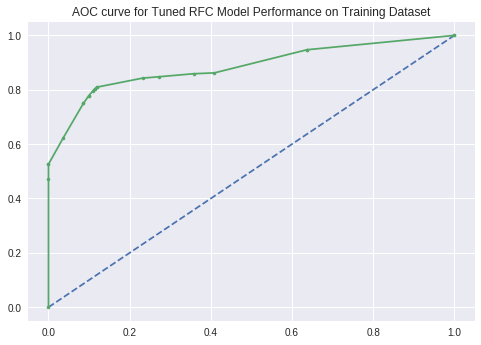

In [0]:
#Plotting AOC curve
probs_train_rfc_random = rfc_random.predict_proba(X_train)
probs_train_rfc_random = probs_train_rfc_random[:, 1]
auc_train_rfc_random = roc_auc_score(y_train, probs_train_rfc_random)
print('AUC: %.3f' % auc_train_rfc_random)
# calculate roc curve
fpr_train_rfc_random, tpr_train_rfc_random, thresholds_train_rfc_random = roc_curve(y_train, probs_train_rfc_random)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_train_rfc_random, tpr_train_rfc_random, marker='.')
plt.title('AOC curve for Tuned RFC Model Performance on Training Dataset')
# show the plot
plt.show()

**Pefromance of the Tuned Random Forest Classifier on the test Dataset**

Confusion matrix, without normalization
[[26548  3423]
 [ 2915  9035]]


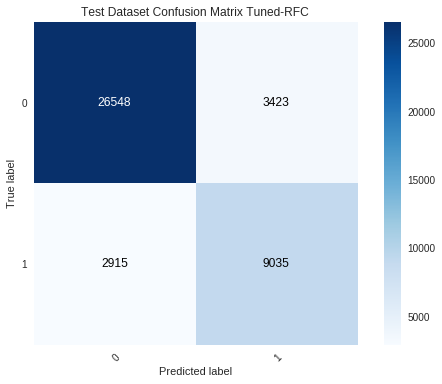

In [0]:
#Checks the tuned performance on the test dataset
class_names=np.array((0,1))
plot_confusion_matrix(y_test, y_pred_rfc_random, classes=class_names, title='Test Dataset Confusion Matrix Tuned-RFC')

In [0]:
#Checks the Tuned performance on Test Dataset
print(classification_report(y_test,y_pred_rfc_random))  
print(accuracy_score(y_test, y_pred_rfc_random))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     29971
           1       0.73      0.76      0.74     11950

   micro avg       0.85      0.85      0.85     41921
   macro avg       0.81      0.82      0.82     41921
weighted avg       0.85      0.85      0.85     41921

0.8488108585195964


AUC: 0.858


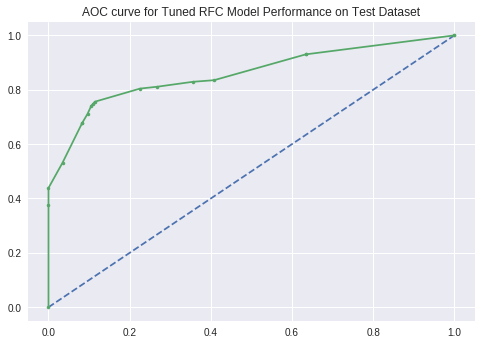

In [0]:
#Plotting AOC curve
probs_rfc_random = rfc_random.predict_proba(X_test)
probs_rfc_random = probs_rfc_random[:, 1]
auc_rfc_random = roc_auc_score(y_test, probs_rfc_random)
print('AUC: %.3f' % auc_rfc_random)
# calculate roc curve
fpr_rfc_random, tpr_rfc_random, thresholds_rfc_random = roc_curve(y_test, probs_rfc_random)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rfc_random, tpr_rfc_random, marker='.')
plt.title('AOC curve for Tuned RFC Model Performance on Test Dataset')
# show the plot
plt.show()

####**Summary of Random Forest Classifier**

The tuned random forest classifier outperforms the original on the test dataset by preventing overfitting.

The Monitored performance metric, Recall on the Original Model was **0.60** while that on the tuned model is **0.76**. This represents an increase of about **16%** 

####**Implementing the Neural Network Classifier**

In [0]:
#Trains The Neural Network Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,10,10), random_state=1)
clf.fit(X_train, y_train)  


In [0]:
# This produces the predictions of the model on the training and test dataset
y_pred_nn = clf.predict(X_test)
y_train_pred_nn=clf.predict(X_train)

**Performance of the Neural Network on the Training Dataset**

Confusion matrix, without normalization
[[61904  8840]
 [15856 54888]]


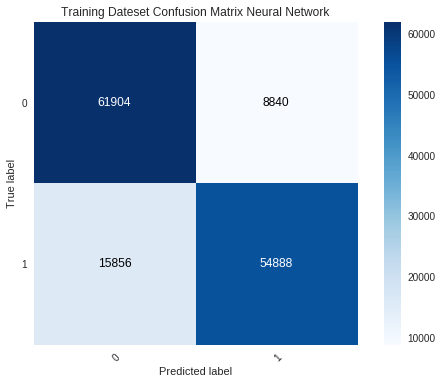

In [0]:
#Plot confusion matrix for Neural Network
class_names=np.array((0,1))
plot_confusion_matrix(y_train, y_train_pred_nn, classes=class_names, title='Training Dateset Confusion Matrix Neural Network')

In [0]:
#Checks the performance on Training Dataset
print(classification_report(y_train,y_train_pred_nn))  
print(accuracy_score(y_train, y_train_pred_nn))


              precision    recall  f1-score   support

           0       0.80      0.88      0.83     70744
           1       0.86      0.78      0.82     70744

   micro avg       0.83      0.83      0.83    141488
   macro avg       0.83      0.83      0.83    141488
weighted avg       0.83      0.83      0.83    141488

0.825455162275246


AUC: 0.897


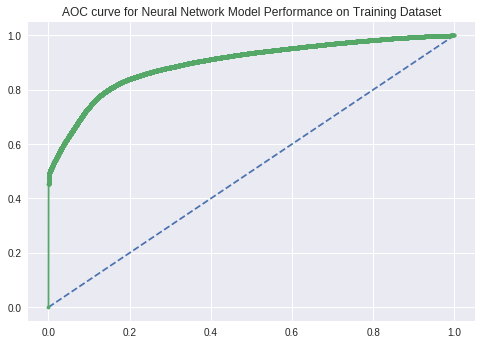

In [0]:
#Plotting AOC curve
probs_train_nn = clf.predict_proba(X_train)
probs_train_nn = probs_train_nn[:, 1]
auc_train_nn = roc_auc_score(y_train, probs_train_nn)
print('AUC: %.3f' % auc_train_nn)
# calculate roc curve
fpr_train_nn, tpr_train_nn, thresholds_train_nn = roc_curve(y_train, probs_train_nn)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_train_nn, tpr_train_nn, marker='.')
plt.title('AOC curve for Neural Network Model Performance on Training Dataset')
# show the plot
plt.show()

**Performance of the Neural Network on the test dataset**

Confusion matrix, without normalization
[[26349  3622]
 [ 2931  9019]]


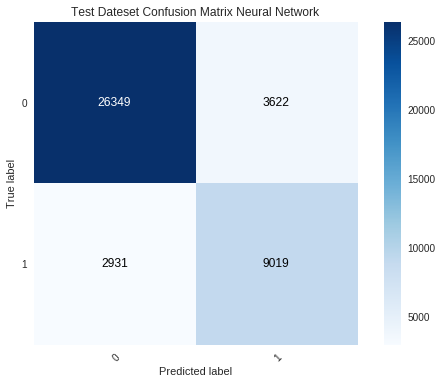

In [0]:
#Plot confusion matrix for Neural Network
class_names=np.array((0,1))
plot_confusion_matrix(y_test, y_pred_nn, classes=class_names, title='Test Dateset Confusion Matrix Neural Network')

In [0]:
#Checking the test Dataset
print(classification_report(y_test,y_pred_nn))  
print(accuracy_score(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     29971
           1       0.71      0.75      0.73     11950

   micro avg       0.84      0.84      0.84     41921
   macro avg       0.81      0.82      0.81     41921
weighted avg       0.85      0.84      0.84     41921

0.8436821640705136


AUC: 0.875


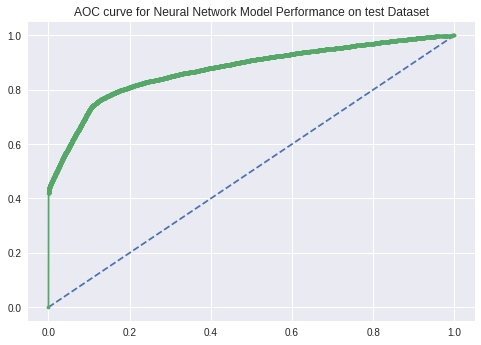

In [0]:
#Plotting AOC curve
probs_nn = clf.predict_proba(X_test)
probs_nn = probs_nn[:, 1]
auc_nn = roc_auc_score(y_test, probs_nn)
print('AUC: %.3f' % auc_nn)
# calculate roc curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, probs_nn)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_nn, tpr_nn, marker='.')
plt.title('AOC curve for Neural Network Model Performance on test Dataset')
# show the plot
plt.show()

**Summary of Neural Network Model**

The neural network has a recall score of **0.78** on the training dataset and **0.75** on the test dataset. The AUC scores are also comparable, this indicates that the model trends well on both datasets and might not offer significant opportunity in terms of hyperparameter tuning.

Due to the significant computational time required to gridsearch for Neural Networks, this process is neglected at this time and the current model is accepted for comparison with the Random Forest Classifier

####**Comparison of the Tuned Random Forest Classifier and Neural Network**

This section aims to compare the performance of the two models with the aim of determing which performs better and exploring where they conflict and whether a combination can be explored

In [0]:
#This confirms the shape of the Tuned Random Forest Model Prediction
y_pred_rfc_random.shape


(41921,)

In [0]:
#This confirms the shape of the Neural Network Model Prediction
y_pred_nn.shape

(41921,)

In [0]:
#This combines the two arrays
testing=pd.DataFrame(data={'0':y_pred_nn,'1':y_pred_rfc_random})
#This subsets the predictions in which they differ
updated_testing=testing.loc[testing['0']!=testing['1']]
#This subsets the predictions in which they differ from the test dataset
y_test_updated=y_test[updated_testing.index]


In [0]:
#This prints the confusion matrix for the differing predicitions for the Neural Network
print(confusion_matrix(y_test_updated,updated_testing['0']))

[[155 354]
 [120 104]]


In [0]:
#This prints the confusion matrix for the differing predicitons for the Tuned Random Forest
print(confusion_matrix(y_test_updated,updated_testing['1']))


[[354 155]
 [104 120]]


Comparing the confusion matrix shows that the Tuned Random Forest Model does better at predicting customers who won't default on their loans and slightly better at predicting those who would (16 extra customers).

This is concordant with the performance metrics in terms of Accuracy, AOC and Recall and therefore, the Random Forest Classifier is recommended. It is also worthy of mention that random forests are capable of performing well on imbalanced datasets.

**P.S** The Neural Network has not been extensively tuned and this might represent significant opportunity that can be explored